In [32]:
import pandas
import multiprocessing

from tqdm import tqdm
from numpy import array
from matplotlib import pyplot as plt

from sklearn import utils
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics.cluster.unsupervised import silhouette_samples, silhouette_score

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from pyod.models.lof import LOF

from nltk.cluster import KMeansClusterer, cosine_distance

## Defining all classes

In [33]:
class Doc2VecTransformer(BaseEstimator):
    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        print("From pipeline instantiating Doc2VecTransformer.")
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
    def fit(self, x, y=None):
        print("From pipeline itting method of Doc2VecTransformer called.")
        # TaggedDocument has a words list and tags list
        tagged_x = [TaggedDocument(preprocess_string(item), [index]) for index, item in enumerate(x)]
        #“Doc2Vec” works really well in understanding the contextual meaning of text
        # (as compared to Tf-Idf which is nothing but pure frequency-based model)
        # Doc2Vec for a document is generated by training a neural network against neighbourhood word
        # of a randomly sampled word and vice versa. 
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)
        for epoch in range(self.epochs):
            model.train(shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha
        self._model = model
        return self
    def transform(self, x):
        print("Transform method of Doc2VecTransformer called.")
        arr = array([self._model.infer_vector(preprocess_string(item))
                                     for index, item in enumerate(x)])
        print("Columns of the 2D-array are the actual feature vectors of ‘Doc2Vec’. We have {} columns.".format(arr.shape[1]))
        return arr

class OptimalKMeansTextsClusterTransformer(BaseEstimator):
    def __init__(self, min_k, max_k):
        print("Instantiating OptimalKMeansTextsClusterTransformer.")
        self.min_k = min_k
        self.max_k = max_k
    def fit(self, x, y=None):
        return self
    def _silhouette_score_with_k_(self, vectors, k):
        clusterer = KMeansClusterer(num_means=k, distance=cosine_distance, repeats=3,avoid_empty_clusters=True)
        cluster_labels = clusterer.cluster(vectors=vectors, assign_clusters=True, trace=False)
        silhouette_score_k = silhouette_score(X=vectors, labels=cluster_labels, metric='cosine')
        return k, silhouette_score_k
    def _determine_k_for_max_silhouette_score_(self, process_responses):
        max_silhoutte_score = -100.0
        optimal_k = 2
        for index, process_response in enumerate(process_responses):
            current_k, silhouette_score_k = process_response.get()
            print('Silhoutte Score: ', silhouette_score_k, ' for k', current_k)
            if silhouette_score_k > max_silhoutte_score:
                max_silhoutte_score = silhouette_score_k
                optimal_k = current_k
        return optimal_k

    def transform(self, x):
        print("Transform function of OptimalKMeansTextsClusterTransformer called.")
        range_of_k = [x for x in range(self.min_k, self.max_k)]
        clusterer_pool = multiprocessing.Pool(processes=len(range_of_k))
        clusterer_process_responses = []
        for k in range_of_k:
            clusterer_process_responses.append(clusterer_pool.apply_async(self._silhouette_score_with_k_, args=(x, k,)))

        optimal_k = self._determine_k_for_max_silhouette_score_(process_responses=clusterer_process_responses)
        clusterer_pool.close()
        print("Optimal k: ", optimal_k)
        optimal_clusterer = KMeansClusterer(num_means=optimal_k, distance=cosine_distance, repeats=3)
        optimal_cluster_labels = optimal_clusterer.cluster(vectors=x, assign_clusters=True, trace=False)
        return x, optimal_cluster_labels

## Defining all functions

In [45]:
def _read_all_health_tweets():
    all_tweets = {}
    file = open('Health-Tweets/nytimeshealth.txt', 'r') #place training data here
    lines = file.readlines()
    sublines = lines[:8000]
    for index, line in enumerate(sublines):
        parts = line
        tweet = "".join(parts.replace('\n',''))
        all_tweets[index] = tweet

    file.close()
    return all_tweets
def sort_key(t):
    return t[0]
def plot_tweets_k_means_clusters_with_anomalies(pca_vectors, cluster_labels, pca_vectors_anomalies):
    pca_vectors_anomalies_x = []
    pca_vectors_anomalies_y = []

    for pca_vectors_elem in pca_vectors_anomalies:
        pca_vectors_anomalies_x.append(pca_vectors_elem[1])
        pca_vectors_anomalies_y.append(pca_vectors_elem[0])

    plt.xlabel('Principal Component 2')
    plt.ylabel('Principal Component 1')
    plt.title('Kmeans Cluster of Messages')

    plt.scatter(x=pca_vectors[:, 1], y=pca_vectors[:, 0], c=cluster_labels)
    plt.scatter(x=pca_vectors_anomalies_x, y=pca_vectors_anomalies_y, marker='^')
    plt.show()
def plot_scatter_silhouette_scores(top_n_silhouette_scores, tweets, silhouette_score_per_tweet):
    plt.close('all')
    plt.figure(figsize=(15,10))
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle('Silhouette Scores vs Messages')
    sub_plot_scatter_silhouette_scores(ax=ax1, top_n_silhouette_scores=top_n_silhouette_scores,
                                       tweets=tweets,
                                       silhouette_score_per_tweet=silhouette_score_per_tweet,
                                       with_annotation=False)

    sub_plot_scatter_silhouette_scores(ax=ax2, top_n_silhouette_scores=top_n_silhouette_scores,
                                       tweets=tweets,
                                       silhouette_score_per_tweet=silhouette_score_per_tweet,
                                       with_annotation=True)
    plt.show()
    
def sub_plot_scatter_silhouette_scores(ax,top_n_silhouette_scores, tweets, silhouette_score_per_tweet, with_annotation):
    ax.set(xlabel='Message Index', ylabel='Silhouette Score')
    ax.scatter(*zip(*silhouette_score_per_tweet))
    ax.scatter(*zip(*top_n_silhouette_scores), edgecolors='red')

    if with_annotation:
        for (index, score) in top_n_silhouette_scores:
            ax.annotate(tweets['TWEET'][index].index, xy=(index, score), xycoords='data')
def determine_anomaly_tweets_k_means(top_n):
    tweets = _read_all_health_tweets()
    tweets = pandas.DataFrame(data=tweets.values(), index=tweets.keys(), columns=['tweets'], dtype=str)
    tweets = tweets["tweets"].str.split("|", n = 2, expand = True)
    tweets.columns = 'id,timestamp,tweet'.upper().split(',')
    print(tweets.head())
    pipeline = Pipeline(steps=[('doc2vec', Doc2VecTransformer()),
                         ('pca', PCA(n_components=2)),
                         ('kmeans', OptimalKMeansTextsClusterTransformer(min_k=2, max_k=5))])
    pipeline.fit(tweets['TWEET'].values)
    pca_vectors, cluster_labels = pipeline.transform(tweets['TWEET'])
    silhouette_values = silhouette_samples(X=pca_vectors, labels=cluster_labels, metric='cosine')
    tweet_index_silhouette_scores = []
    absolute_silhouette_scores_tweet_index = []

    for index, sh_score in enumerate(silhouette_values):
        absolute_silhouette_scores_tweet_index.append((abs(sh_score), index))
        tweet_index_silhouette_scores.append((index, sh_score))

    sorted_scores = sorted(absolute_silhouette_scores_tweet_index, key=sort_key)

    top_n_silhouette_scores = []
    pca_vectors_anomalies = []
    analomiesIndex = []
    print("Top ", top_n, " anomalies")
    for i in range(top_n):
        abs_sh_score, index = sorted_scores[i]
        index_1, sh_score = tweet_index_silhouette_scores[index]
        top_n_silhouette_scores.append((index, sh_score))
        print(tweets['TWEET'][index])
        analomiesIndex.append(index)
        print('PCA vector', pca_vectors[index])
        pca_vectors_anomalies.append(pca_vectors[index])
        print('Silhouette Score: ', sh_score)
        print("..................")

    plot_tweets_k_means_clusters_with_anomalies(pca_vectors=pca_vectors, pca_vectors_anomalies=pca_vectors_anomalies,
                                                cluster_labels=cluster_labels)
    plot_scatter_silhouette_scores(top_n_silhouette_scores=top_n_silhouette_scores,
                                   tweets=tweets,
                                   silhouette_score_per_tweet=tweet_index_silhouette_scores)
    
    return analomiesIndex

In [ ]:
vectors_df = pipeline.steps[0][1].fit(tweets['TWEET'].values).transform(tweets['TWEET'].values)

# 
print("Dimentionality of vector: ",vectors_df.shape[1])

# too much features may spoil the actual purpose. So reducing dimensionality
pca_vectors = pipeline.steps[1][1].fit_transform(vectors_df)
for index, var in enumerate(pipeline.steps[1][1].explained_variance_ratio_):
    print("Explained Variance ratio by Principal Component_", (index+1), ": ", var)
print("\nFirst 2 components explain the maximum variance. So using them.")

## Main

                   ID                       TIMESTAMP  \
0  548662191340421120  Sat Dec 27 02:10:34 +0000 2014   
1  548579831169163265  Fri Dec 26 20:43:18 +0000 2014   
2  548579045269852161  Fri Dec 26 20:40:11 +0000 2014   
3  548444679529041920  Fri Dec 26 11:46:15 +0000 2014   
4  548311901227474944  Fri Dec 26 02:58:39 +0000 2014   

                                               TWEET  
0  Risks in Using Social Media to Spot Signs of M...  
1  RT @paula_span: The most effective nationwide ...  
2  The New Old Age Blog: Diabetes Prevention That...  
3  Well: Comfort Casseroles for Winter Dinners ht...  
4  High-Level Knowledge Before Veterans Affairs S...  
Instantiating Doc2VecTransformer.
Instantiating OptimalKMeansTextsClusterTransformer.
Fitting method of Doc2VecTransformer called.


100%|██████████| 6245/6245 [00:00<00:00, 1984050.03it/s]


Transform method of Doc2VecTransformer called.
Transform method of Doc2VecTransformer called.
Transform function of OptimalKMeansTextsClusterTransformer called.
Silhoutte Score:  0.9134009  for k 2
Silhoutte Score:  0.9215738  for k 3
Silhoutte Score:  0.924607  for k 4
Optimal k:  4
Top  100  anomalies
RT @celiadugger: Fear and rage in Guinea: Mob kills journalist and officials at Ebola community awareness event. http://nyti.ms/1r5hEzu
PCA vector [0.04271439 0.05841115]
Silhouette Score:  -4.0104016e-05
..................
Letters: Tests for Newborns (1 Letter) http://nyti.ms/1dbYl2G
PCA vector [-0.09436481  0.09108204]
Silhouette Score:  0.0013916804
..................
Well: New Doubts About Ginkgo Biloba http://nyti.ms/Y9goyc
PCA vector [ 0.77963567 -0.3363554 ]
Silhouette Score:  0.0054678014
..................
Dr. Melvin J. Glimcher, Prosthetics Innovator, Dies at 88 http://nyti.ms/1jCLip1
PCA vector [ 0.84788215 -0.36591974]
Silhouette Score:  0.0060561844
..................
RT @c

<IPython.core.display.Javascript object>


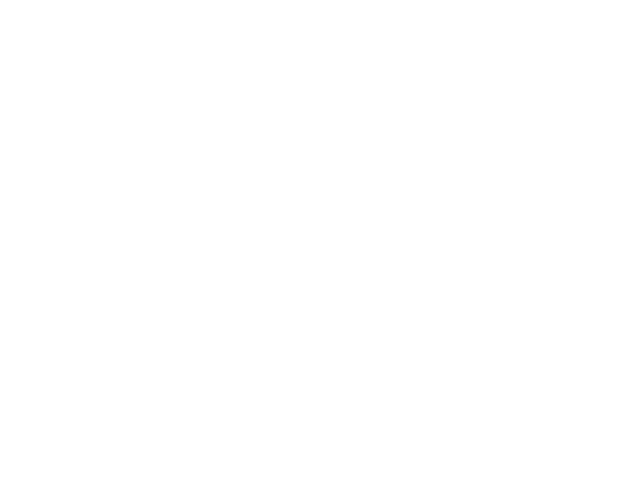

<IPython.core.display.Javascript object>


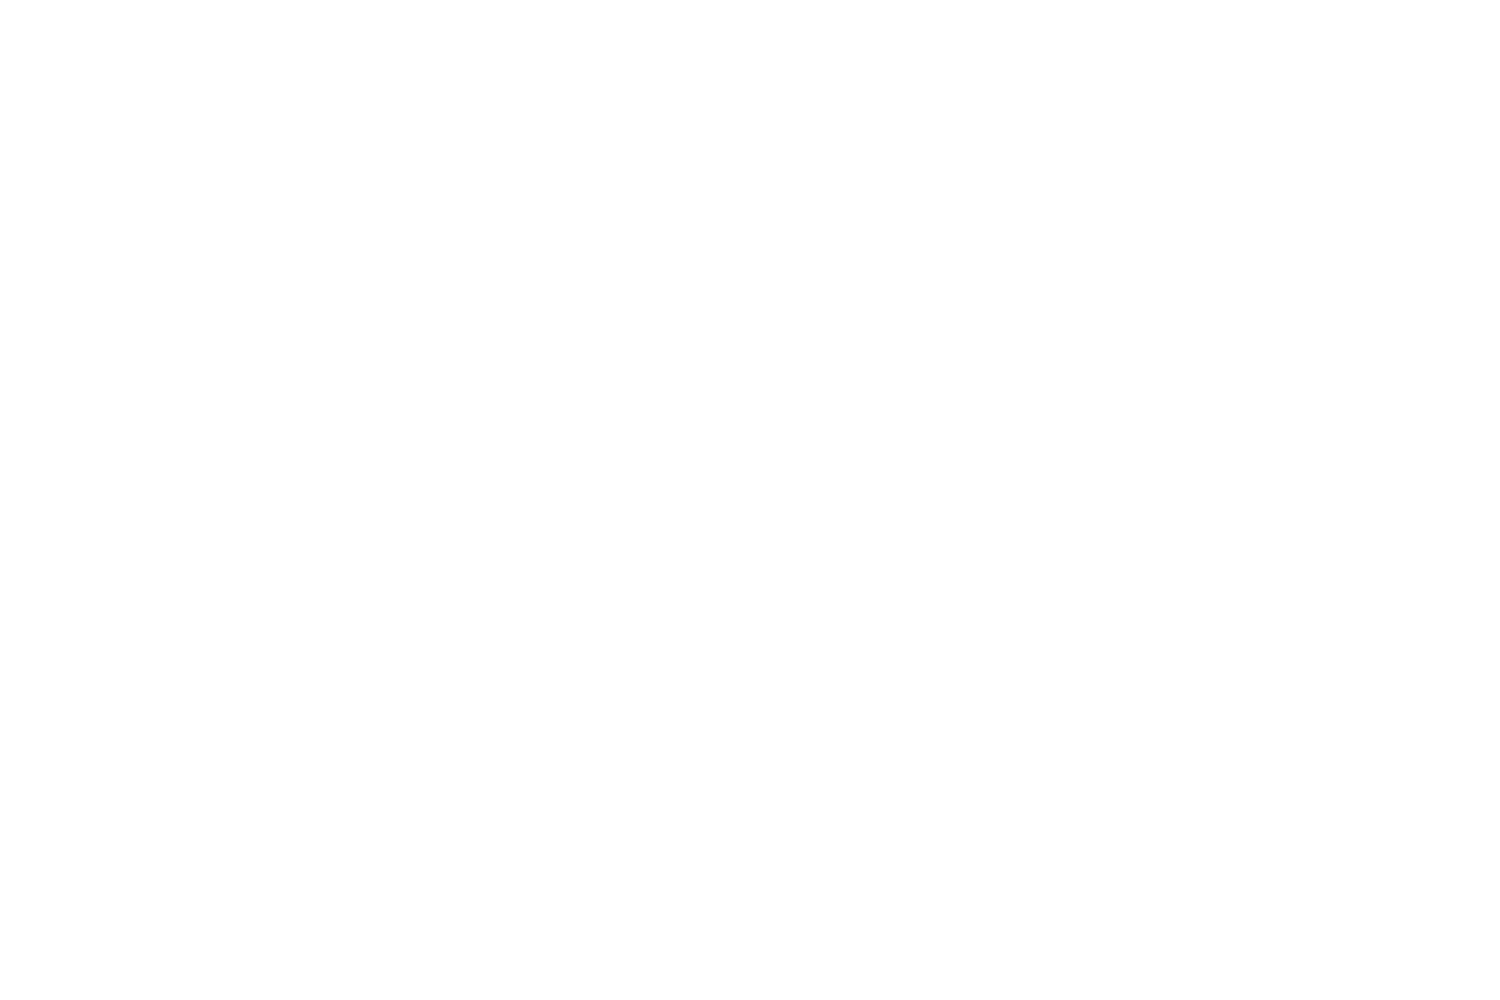

<IPython.core.display.Javascript object>


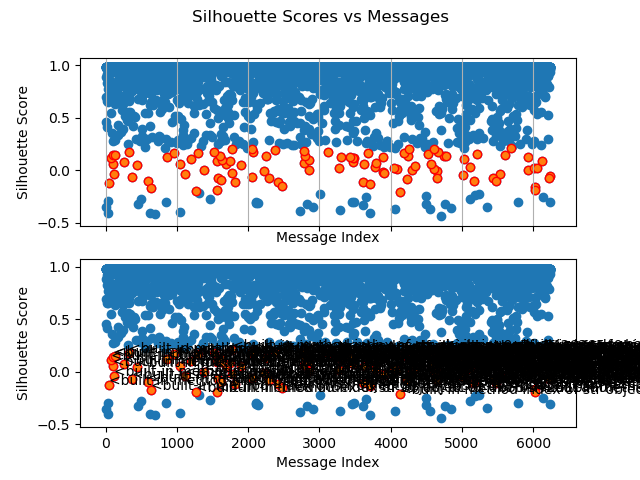

In [46]:
# For outlier detection using ‘Silhoutte Score’(ratio of inter-cluster and intra-cluster distance)  of ‘kmeans’.
# Its value ranges from -1 to 1.
"""
 Value close to -1 : The data point is wrongly put in a cluster to which ideally it should not belong to.
                    Basically it is an ‘inlier’.
 Value close to 0: The data point should not belong to any cluster and should be separated out.
                   It is an ‘outlier’ or ‘anomaly’.
 Value close to 1: The data point is perfectly placed in a right cluster.
"""
# Distances are calculated as inverse of cosine similarity between PCA vectors
# as because it is less sensitive to magnitude & preferable over ‘euclidean’ or generalised ‘minkowski’
# distance for text analytics.
%matplotlib notebook
anamoliesDetected =  determine_anomaly_tweets_k_means(top_n=100)